In [46]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import ParameterGrid
import keras_tuner as kt
from tensorflow.keras.applications import VGG16, MobileNetV2, EfficientNetB0, ResNet50
from tensorflow.keras.optimizers import Adam
import warnings
from PIL import Image
warnings.filterwarnings('ignore')

In [47]:
IMAGE_SIZE = 256
BATCH_SIZE = 32

### Loading data from the directory

In [48]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    shuffle = True,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [49]:
class_names = dataset.class_names
print(class_names)

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']


### Visualizing the data

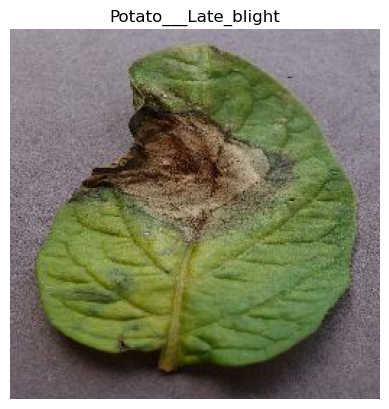

In [50]:
for image_batch, label_batch in dataset.take(1):
    plt.imshow(image_batch[0].numpy().astype("uint8"))
    plt.title(class_names[label_batch[0]])
    plt.axis("off")

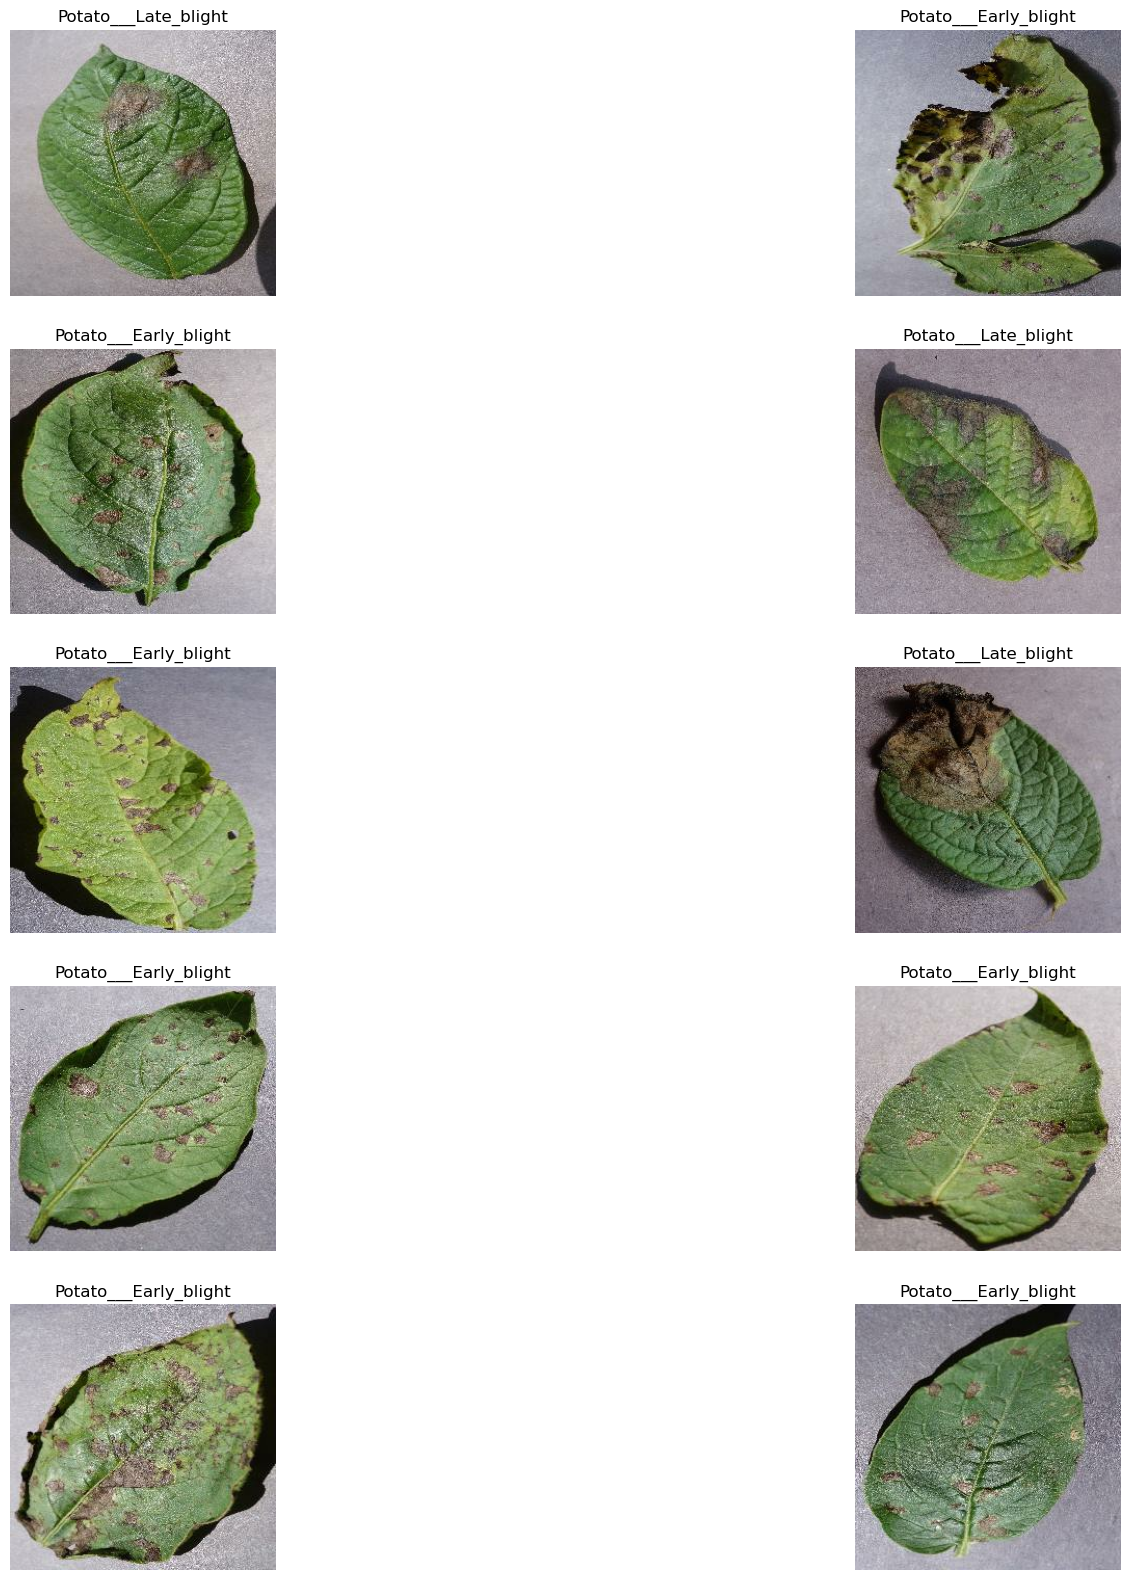

In [51]:
plt.figure(figsize = (20,20))
for image_batch, label_batch in dataset.take(1):
    for i in range(10):
        ax = plt.subplot(5,2, i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

In [52]:
len(dataset)

68

### Creating partitions of dataset to training, validation and testing data.

In [53]:
def get_dataset_partitions_tf(ds, train_split = 0.8 , val_split = 0.1, test_split = 0.1, shuffle = True, shuffle_size = 10000):
    ds_size = len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed = 12)
    
    train_ds = ds.take(int(train_split * ds_size))
    val_ds = ds.skip(len(train_ds)).take(int(val_split * ds_size))
    test_ds = ds.skip(len(train_ds)).skip(len(val_ds))
    return train_ds , val_ds , test_ds

In [54]:
train_ds , val_ds , test_ds =get_dataset_partitions_tf(dataset)

In [55]:
print(len(train_ds) , len(val_ds) , len(test_ds))

54 6 8


### Optimizing the dataset 
This is done by caching data in memory, shuffling the elements, and prefetching them with a dynamically adjusted buffer size.

In [56]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE) 
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE) 

### Image Resizing and Rescaling

In [57]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

### Data Augmentation

In [58]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
])

### Fully connected Neural Network

In [59]:
n_classes = 3
NN_model = models.Sequential([
    resize_and_rescale,
    # data_augmentation,
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax')
])

NN_model.build(input_shape = (BATCH_SIZE,IMAGE_SIZE,IMAGE_SIZE,3))

NN_model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
        metrics=['accuracy']
    )

NN_history = NN_model.fit(train_ds,
    epochs = 50,
    batch_size = BATCH_SIZE,
    validation_data=val_ds
)

Epoch 1/50
54/54 [==============================] - 15s 149ms/step - loss: 1.5298 - accuracy: 0.6279 - val_loss: 0.6949 - val_accuracy: 0.7812
Epoch 2/50
54/54 [==============================] - 6s 109ms/step - loss: 0.6732 - accuracy: 0.7465 - val_loss: 0.6076 - val_accuracy: 0.7500
Epoch 3/50
54/54 [==============================] - 6s 112ms/step - loss: 0.5276 - accuracy: 0.7957 - val_loss: 0.4767 - val_accuracy: 0.8229
Epoch 4/50
54/54 [==============================] - 6s 119ms/step - loss: 0.5153 - accuracy: 0.7980 - val_loss: 0.7996 - val_accuracy: 0.6615
Epoch 5/50
54/54 [==============================] - 7s 120ms/step - loss: 0.5779 - accuracy: 0.7899 - val_loss: 0.5782 - val_accuracy: 0.7500
Epoch 6/50
54/54 [==============================] - 6s 112ms/step - loss: 0.4619 - accuracy: 0.8194 - val_loss: 0.3393 - val_accuracy: 0.8750
Epoch 7/50
54/54 [==============================] - 7s 131ms/step - loss: 0.3546 - accuracy: 0.8709 - val_loss: 0.3686 - val_accuracy: 0.8385
Epoch

In [60]:
NN_model.summary()
test_score = NN_model.evaluate(test_ds)
print(test_score)
print(f"Test Accuracy: {test_score[1]}")

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_16 (Sequential)  (None, 256, 256, 3)       0         
                                                                 
 flatten_10 (Flatten)        (None, 196608)            0         
                                                                 
 dense_29 (Dense)            (None, 128)               25165952  
                                                                 
 dense_30 (Dense)            (None, 64)                8256      
                                                                 
 dense_31 (Dense)            (None, 3)                 195       
                                                                 
Total params: 25,174,403
Trainable params: 25,174,403
Non-trainable params: 0
_________________________________________________________________
8/8 [==============================] - 2s

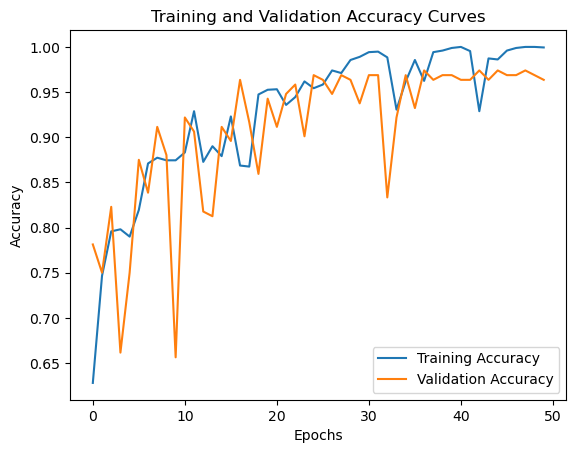

In [61]:
plt.plot(NN_history.history['accuracy'], label='Training Accuracy')
plt.plot(NN_history.history['val_accuracy'], label='Validation Accuracy')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy Curves')
plt.show()

### Convolution Neural Network (CNN)

In [17]:
n_classes = 3
model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32,(3,3), activation='relu', input_shape = (BATCH_SIZE,IMAGE_SIZE,IMAGE_SIZE,3)),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size=(3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size=(3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    
    layers.Dense(64,activation='relu'),
    
    layers.Dense(n_classes, activation='softmax'),
        
])

model.build(input_shape = (BATCH_SIZE,IMAGE_SIZE,IMAGE_SIZE,3))


In [18]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 sequential_1 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                  

In [19]:
model.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics = ['accuracy']
)

In [20]:
history = model.fit(
    train_ds,
    epochs = 20,
    batch_size = BATCH_SIZE,
    validation_data=val_ds
)

Epoch 1/20
54/54 [==============================] - 80s 1s/step - loss: 0.9137 - accuracy: 0.4722 - val_loss: 1.0756 - val_accuracy: 0.4375
Epoch 2/20
54/54 [==============================] - 68s 1s/step - loss: 0.7856 - accuracy: 0.6238 - val_loss: 0.6515 - val_accuracy: 0.6771
Epoch 3/20
54/54 [==============================] - 69s 1s/step - loss: 0.4869 - accuracy: 0.7876 - val_loss: 0.4282 - val_accuracy: 0.8490
Epoch 4/20
54/54 [==============================] - 69s 1s/step - loss: 0.2773 - accuracy: 0.8900 - val_loss: 0.6988 - val_accuracy: 0.7292
Epoch 5/20
54/54 [==============================] - 70s 1s/step - loss: 0.2067 - accuracy: 0.9178 - val_loss: 0.2699 - val_accuracy: 0.9115
Epoch 6/20
54/54 [==============================] - 68s 1s/step - loss: 0.1683 - accuracy: 0.9340 - val_loss: 0.1497 - val_accuracy: 0.9479
Epoch 7/20
54/54 [==============================] - 71s 1s/step - loss: 0.1285 - accuracy: 0.9549 - val_loss: 0.4582 - val_accuracy: 0.8125
Epoch 8/20
54/54 [==

In [21]:
score = model.evaluate(test_ds)

8/8 [==============================] - 2s 276ms/step - loss: 0.0181 - accuracy: 0.9961


First image to predict: 
actual label: Potato___Early_blight
1/1 [==============================] - 2s 2s/step
predicted label:  Potato___Early_blight


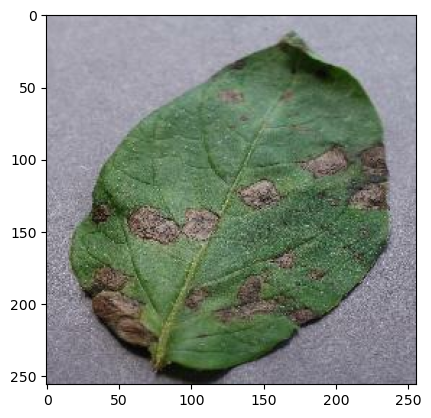

In [22]:
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    print("First image to predict: ")
    plt.imshow(first_image)
    print("actual label:", class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label: ",class_names[np.argmax(batch_prediction[0])])

In [23]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])),2)
    return predicted_class, confidence

1/1 [==============================] - 0s 67ms/step


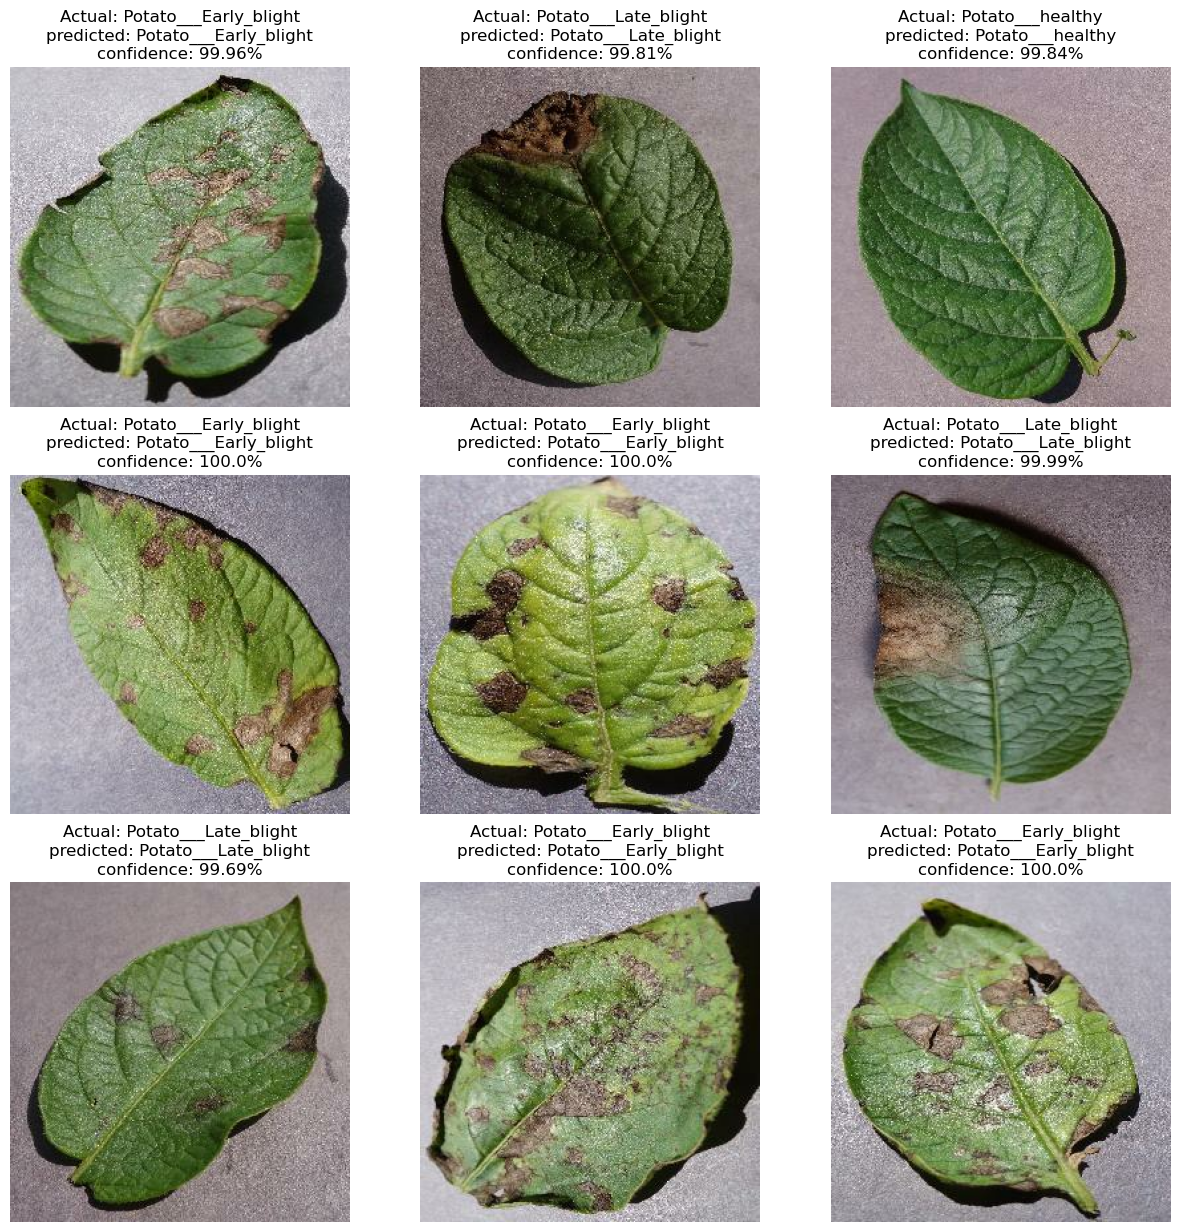

In [24]:
plt.figure(figsize = (15,15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]
        plt.title(f"Actual: {actual_class}\npredicted: {predicted_class}\nconfidence: {confidence}%")
        plt.axis("off")

### Hyperparameter tuning using parameter grid


Training with hyperparameters: {'learning_rate': 0.001, 'num_layers': 3}
Epoch 1/10
54/54 [==============================] - 168s 3s/step - loss: 0.8266 - accuracy: 0.6209 - val_loss: 0.7437 - val_accuracy: 0.7083
Epoch 2/10
54/54 [==============================] - 139s 3s/step - loss: 0.5121 - accuracy: 0.8137 - val_loss: 0.3265 - val_accuracy: 0.8646
Epoch 3/10
54/54 [==============================] - 127s 2s/step - loss: 0.2709 - accuracy: 0.8964 - val_loss: 0.7857 - val_accuracy: 0.8021
Epoch 4/10
54/54 [==============================] - 128s 2s/step - loss: 0.2921 - accuracy: 0.8837 - val_loss: 0.4280 - val_accuracy: 0.8385
Epoch 5/10
54/54 [==============================] - 119s 2s/step - loss: 0.2632 - accuracy: 0.8906 - val_loss: 0.1722 - val_accuracy: 0.9167
Epoch 6/10
54/54 [==============================] - 121s 2s/step - loss: 0.1531 - accuracy: 0.9439 - val_loss: 0.3065 - val_accuracy: 0.8958
Epoch 7/10
54/54 [==============================] - 122s 2s/step - loss: 0.2017 

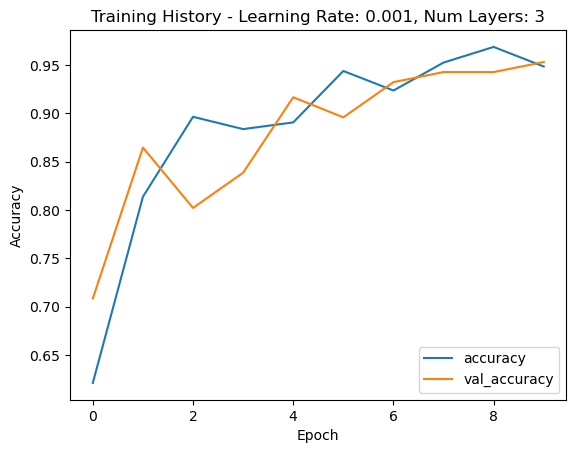


Training with hyperparameters: {'learning_rate': 0.001, 'num_layers': 4}
Epoch 1/10
54/54 [==============================] - 151s 3s/step - loss: 0.7542 - accuracy: 0.6424 - val_loss: 0.5235 - val_accuracy: 0.8073
Epoch 2/10
54/54 [==============================] - 130s 2s/step - loss: 0.4730 - accuracy: 0.8270 - val_loss: 0.4378 - val_accuracy: 0.8177
Epoch 3/10
54/54 [==============================] - 117s 2s/step - loss: 0.3970 - accuracy: 0.8559 - val_loss: 0.4096 - val_accuracy: 0.8542
Epoch 4/10
54/54 [==============================] - 121s 2s/step - loss: 0.3108 - accuracy: 0.8785 - val_loss: 0.3395 - val_accuracy: 0.8802
Epoch 5/10
54/54 [==============================] - 121s 2s/step - loss: 0.2787 - accuracy: 0.9068 - val_loss: 0.2273 - val_accuracy: 0.9167
Epoch 6/10
54/54 [==============================] - 122s 2s/step - loss: 0.2453 - accuracy: 0.9132 - val_loss: 0.2871 - val_accuracy: 0.8906
Epoch 7/10
54/54 [==============================] - 122s 2s/step - loss: 0.2332 

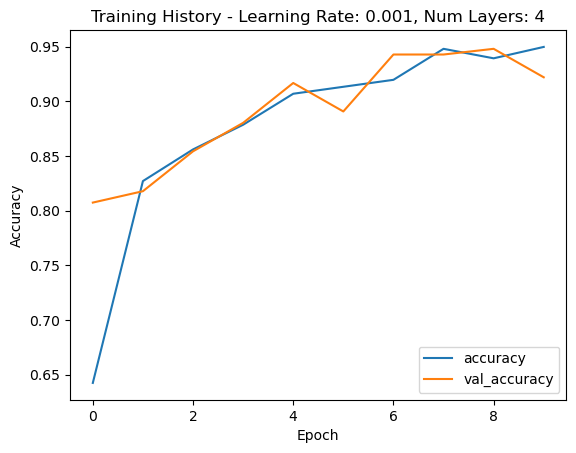


Training with hyperparameters: {'learning_rate': 0.001, 'num_layers': 5}
Epoch 1/10
54/54 [==============================] - 126s 2s/step - loss: 0.9388 - accuracy: 0.4896 - val_loss: 0.8479 - val_accuracy: 0.7344
Epoch 2/10
54/54 [==============================] - 126s 2s/step - loss: 0.6078 - accuracy: 0.7656 - val_loss: 0.4483 - val_accuracy: 0.8125
Epoch 3/10
54/54 [==============================] - 123s 2s/step - loss: 0.3710 - accuracy: 0.8542 - val_loss: 0.3393 - val_accuracy: 0.8281
Epoch 4/10
54/54 [==============================] - 122s 2s/step - loss: 0.4352 - accuracy: 0.8235 - val_loss: 0.3358 - val_accuracy: 0.8698
Epoch 5/10
54/54 [==============================] - 122s 2s/step - loss: 0.2662 - accuracy: 0.8866 - val_loss: 0.2629 - val_accuracy: 0.9010
Epoch 6/10
54/54 [==============================] - 123s 2s/step - loss: 0.2851 - accuracy: 0.8843 - val_loss: 0.4385 - val_accuracy: 0.8073
Epoch 7/10
54/54 [==============================] - 122s 2s/step - loss: 0.2151 

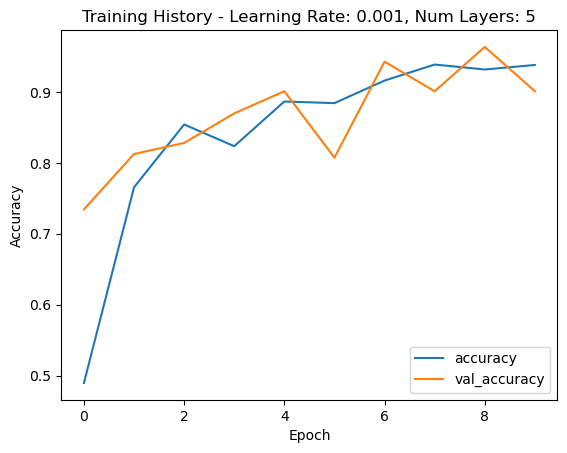


Training with hyperparameters: {'learning_rate': 0.0001, 'num_layers': 3}
Epoch 1/10
54/54 [==============================] - 140s 3s/step - loss: 0.8647 - accuracy: 0.5816 - val_loss: 0.7322 - val_accuracy: 0.8177
Epoch 2/10
54/54 [==============================] - 129s 2s/step - loss: 0.5315 - accuracy: 0.8281 - val_loss: 0.4493 - val_accuracy: 0.8333
Epoch 3/10
54/54 [==============================] - 121s 2s/step - loss: 0.3545 - accuracy: 0.8634 - val_loss: 0.3240 - val_accuracy: 0.8594
Epoch 4/10
54/54 [==============================] - 117s 2s/step - loss: 0.2842 - accuracy: 0.8906 - val_loss: 0.3079 - val_accuracy: 0.8646
Epoch 5/10
54/54 [==============================] - 119s 2s/step - loss: 0.2236 - accuracy: 0.9149 - val_loss: 0.2407 - val_accuracy: 0.8906
Epoch 6/10
54/54 [==============================] - 120s 2s/step - loss: 0.2054 - accuracy: 0.9167 - val_loss: 0.2606 - val_accuracy: 0.8906
Epoch 7/10
54/54 [==============================] - 124s 2s/step - loss: 0.1562

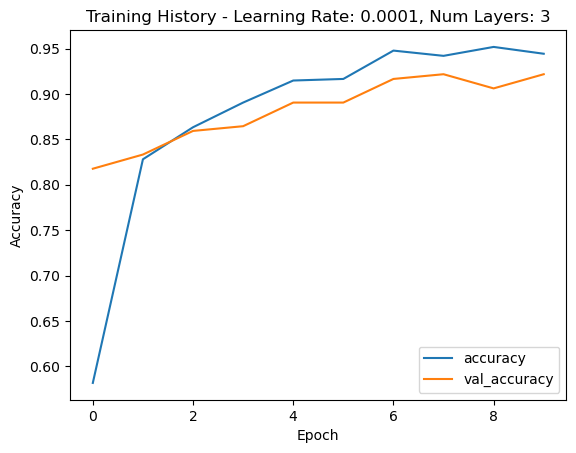


Training with hyperparameters: {'learning_rate': 0.0001, 'num_layers': 4}
Epoch 1/10
54/54 [==============================] - 129s 2s/step - loss: 0.9149 - accuracy: 0.5104 - val_loss: 0.9009 - val_accuracy: 0.5104
Epoch 2/10
54/54 [==============================] - 118s 2s/step - loss: 0.7285 - accuracy: 0.7321 - val_loss: 0.5745 - val_accuracy: 0.8073
Epoch 3/10
54/54 [==============================] - 129s 2s/step - loss: 0.4513 - accuracy: 0.8362 - val_loss: 0.4639 - val_accuracy: 0.8125
Epoch 4/10
54/54 [==============================] - 138s 3s/step - loss: 0.3134 - accuracy: 0.8837 - val_loss: 0.3684 - val_accuracy: 0.8177
Epoch 5/10
54/54 [==============================] - 125s 2s/step - loss: 0.2509 - accuracy: 0.8999 - val_loss: 0.3463 - val_accuracy: 0.8333
Epoch 6/10
54/54 [==============================] - 117s 2s/step - loss: 0.2039 - accuracy: 0.9213 - val_loss: 0.3933 - val_accuracy: 0.8333
Epoch 7/10
54/54 [==============================] - 124s 2s/step - loss: 0.1652

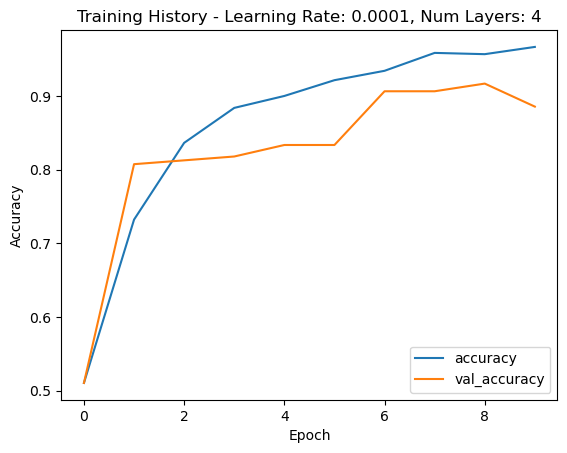


Training with hyperparameters: {'learning_rate': 0.0001, 'num_layers': 5}
Epoch 1/10
54/54 [==============================] - 129s 2s/step - loss: 0.9328 - accuracy: 0.4630 - val_loss: 0.9281 - val_accuracy: 0.4323
Epoch 2/10
54/54 [==============================] - 141s 3s/step - loss: 0.8553 - accuracy: 0.5903 - val_loss: 0.8142 - val_accuracy: 0.7708
Epoch 3/10
54/54 [==============================] - 134s 2s/step - loss: 0.6364 - accuracy: 0.7720 - val_loss: 0.5360 - val_accuracy: 0.7812
Epoch 4/10
54/54 [==============================] - 127s 2s/step - loss: 0.4755 - accuracy: 0.8102 - val_loss: 0.4654 - val_accuracy: 0.7969
Epoch 5/10
54/54 [==============================] - 122s 2s/step - loss: 0.3780 - accuracy: 0.8414 - val_loss: 0.5052 - val_accuracy: 0.7604
Epoch 6/10
54/54 [==============================] - 107s 2s/step - loss: 0.3200 - accuracy: 0.8675 - val_loss: 0.3586 - val_accuracy: 0.8542
Epoch 7/10
54/54 [==============================] - 116s 2s/step - loss: 0.2366

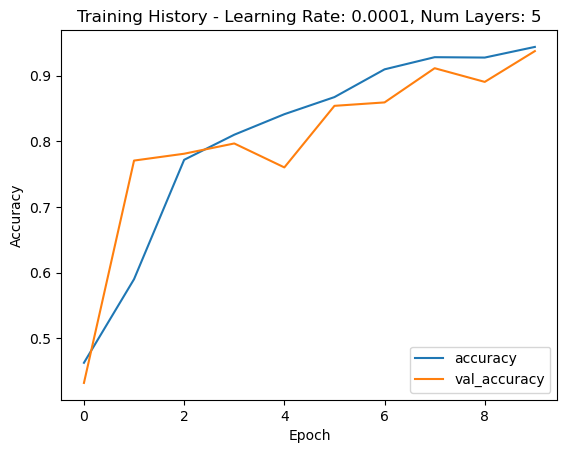

In [26]:
n_classes = 3
param_grid = {
    'learning_rate': [0.001, 0.0001],
    'num_layers': [3, 4, 5],
}

count = 0
for params in ParameterGrid(param_grid):
    print(f"\nTraining with hyperparameters: {params}")

    model = models.Sequential([
        resize_and_rescale,
        data_augmentation,
    ])

    for i in range(params['num_layers']):
        model.add(layers.Conv2D(64, (3, 3), activation='relu'))
        model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Flatten())
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(n_classes, activation='softmax'))

    model.build(input_shape=(BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, 3))

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=params['learning_rate']),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
        metrics=['accuracy']
    )

    history = model.fit(
        train_ds,
        epochs=10,
        batch_size=BATCH_SIZE,
        validation_data=val_ds,
    )

    score = model.evaluate(test_ds)
    print(f"Test Loss: {score[0]}, Test Accuracy: {score[1]}")

    plt.plot(history.history['accuracy'], label='accuracy')
    plt.plot(history.history['val_accuracy'], label='val_accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    plt.title(f"Training History - Learning Rate: {params['learning_rate']}, Num Layers: {params['num_layers']}") 
    plt.savefig(f'my_plot{count}.png')
    count+=1
    plt.show()

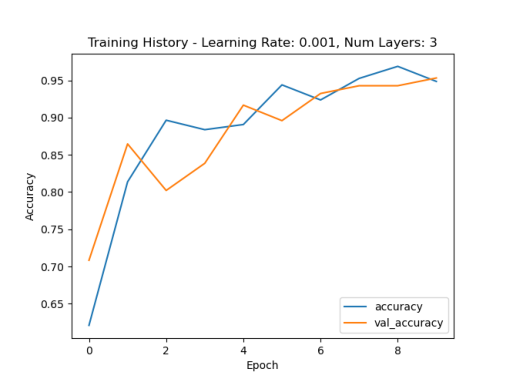

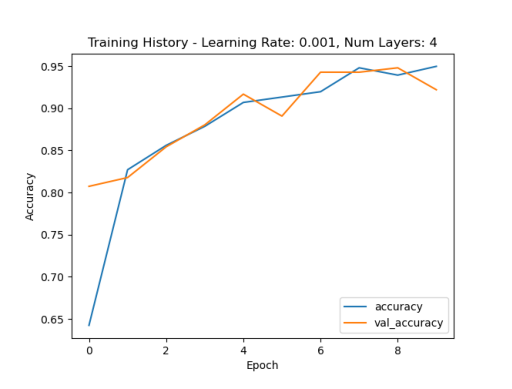

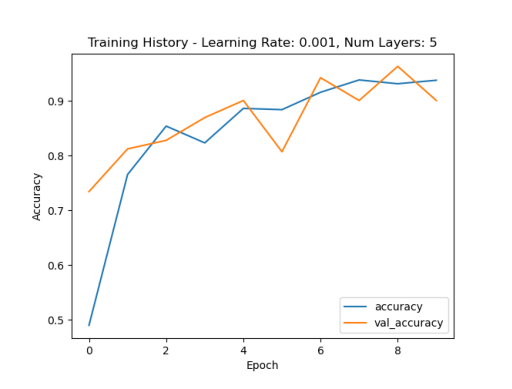

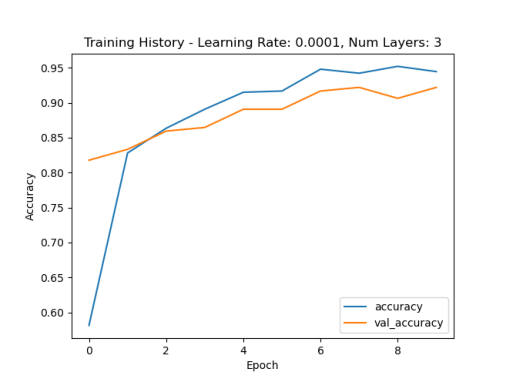

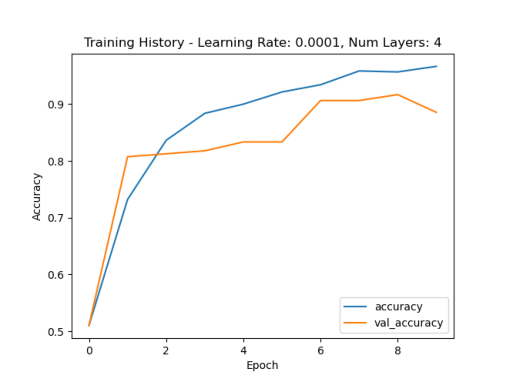

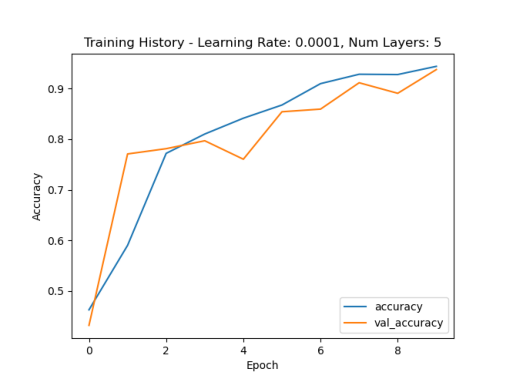

In [27]:
for i in range(6):
    image_path = f'my_plot{i}.png'
    img = Image.open(image_path)

    plt.imshow(img)
    plt.axis('off')
    plt.show()

### Hyperparameter tuning using KerasTuner

In [28]:
def build_CNN(hp):
    n_classes = 3
    model = keras.Sequential([
        resize_and_rescale,
        data_augmentation,
    ])

    num_layers = hp.Int('num_layers', min_value=3, max_value=5, step=1)
    for _ in range(num_layers):
        model.add(layers.Conv2D(hp.Int('num_filters', min_value=32, max_value=64, step=32), (3, 3), activation='relu'))
        model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Flatten())
    model.add(layers.Dense(hp.Int('dense_units', min_value=32, max_value=128, step=32), activation='relu'))
    model.add(layers.Dense(n_classes, activation='softmax'))

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=hp.Choice('learning_rate', values=[1e-3, 1e-4, 1e-5])),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

tuner = kt.Hyperband(
    build_CNN,
    objective='val_accuracy',
    max_epochs=10
)

tuner.search_space_summary()


tuner.search(train_ds, epochs=10, validation_data=val_ds)

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

best_CNN = tuner.hypermodel.build(best_hps)

best_CNN.fit(train_ds, epochs=20, validation_data=val_ds)

Reloading Tuner from .\untitled_project\tuner0.json
Search space summary
Default search space size: 3
num_dense_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 5, 'step': 1, 'sampling': 'linear'}
dense_units (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 128, 'step': 32, 'sampling': 'linear'}
learning_rate (Choice)
{'default': 0.001, 'conditions': [], 'values': [0.001, 0.0001, 1e-05], 'ordered': True}
Epoch 1/20
54/54 [==============================] - 49s 791ms/step - loss: 0.6875 - accuracy: 0.7147 - val_loss: 0.8232 - val_accuracy: 0.7292
Epoch 2/20
54/54 [==============================] - 40s 729ms/step - loss: 0.3705 - accuracy: 0.8681 - val_loss: 0.4355 - val_accuracy: 0.8281
Epoch 3/20
54/54 [==============================] - 39s 725ms/step - loss: 0.2621 - accuracy: 0.9034 - val_loss: 0.5660 - val_accuracy: 0.7656
Epoch 4/20
54/54 [==============================] - 39s 725ms/step - loss: 0.2394 - accuracy: 0.9178 - val_loss

In [29]:
best_CNN.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 sequential_1 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 conv2d_33 (Conv2D)          (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d_33 (MaxPoolin  (None, 127, 127, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_34 (Conv2D)          (None, 125, 125, 32)      9248      
                                                                 
 max_pooling2d_34 (MaxPoolin  (None, 62, 62, 32)       0         
 g2D)                                                

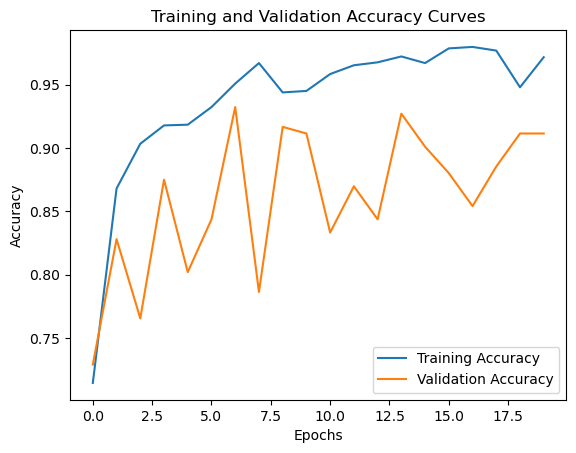

In [30]:
plt.plot(best_CNN.history.history['accuracy'], label='Training Accuracy')
plt.plot(best_CNN.history.history['val_accuracy'], label='Validation Accuracy')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy Curves')
plt.show()

### Using MobileNetV2 Pre-Trained model for our dataset

In [31]:
base_model = MobileNetV2(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3),
                         include_top=False,
                         weights='imagenet')

base_model.trainable = False


n_classes = 3

model = tf.keras.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax')
])


model.compile(optimizer=Adam(learning_rate=1e-3),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


history = model.fit(train_ds, epochs=20, validation_data=val_ds)

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 8, 8, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense_21 (Dense)            (None, 64)                81984     
                                                                 
 dense_22 (Dense)            (None, 3)                 195       
                                                                 
Total params: 2,340,163
Trainable params: 82,179
Non-trainable params: 2,257,984
_________________________________________________________________
Epoch 1/20
54/54 [====================

In [32]:
score = model.evaluate(test_ds)
print("Test Accuracy:", score[1])

8/8 [==============================] - 5s 579ms/step - loss: 0.0235 - accuracy: 0.9961
Test Accuracy: 0.99609375


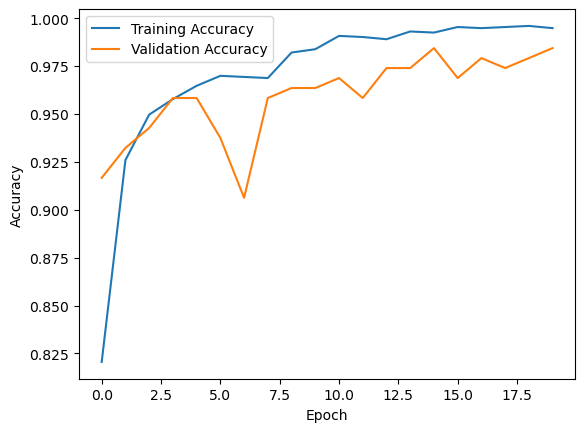

In [33]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Bell Pepper Classication using various Pre-trained models

In [34]:
bell_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "Bell Pepper",
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size= BATCH_SIZE
)

Found 2475 files belonging to 2 classes.


In [35]:
class_names = bell_ds.class_names

### Data Visualization

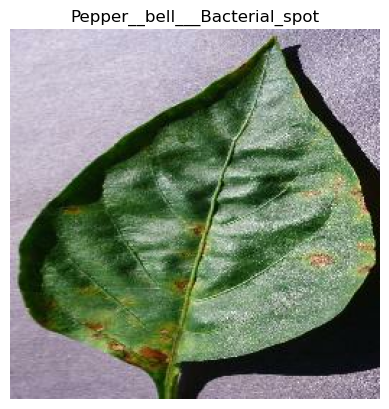

In [36]:
for image_batch, label_batch in bell_ds.take(1):
    plt.imshow(image_batch[0].numpy().astype("uint8"))
    plt.title(class_names[label_batch[0]])
    plt.axis("off")

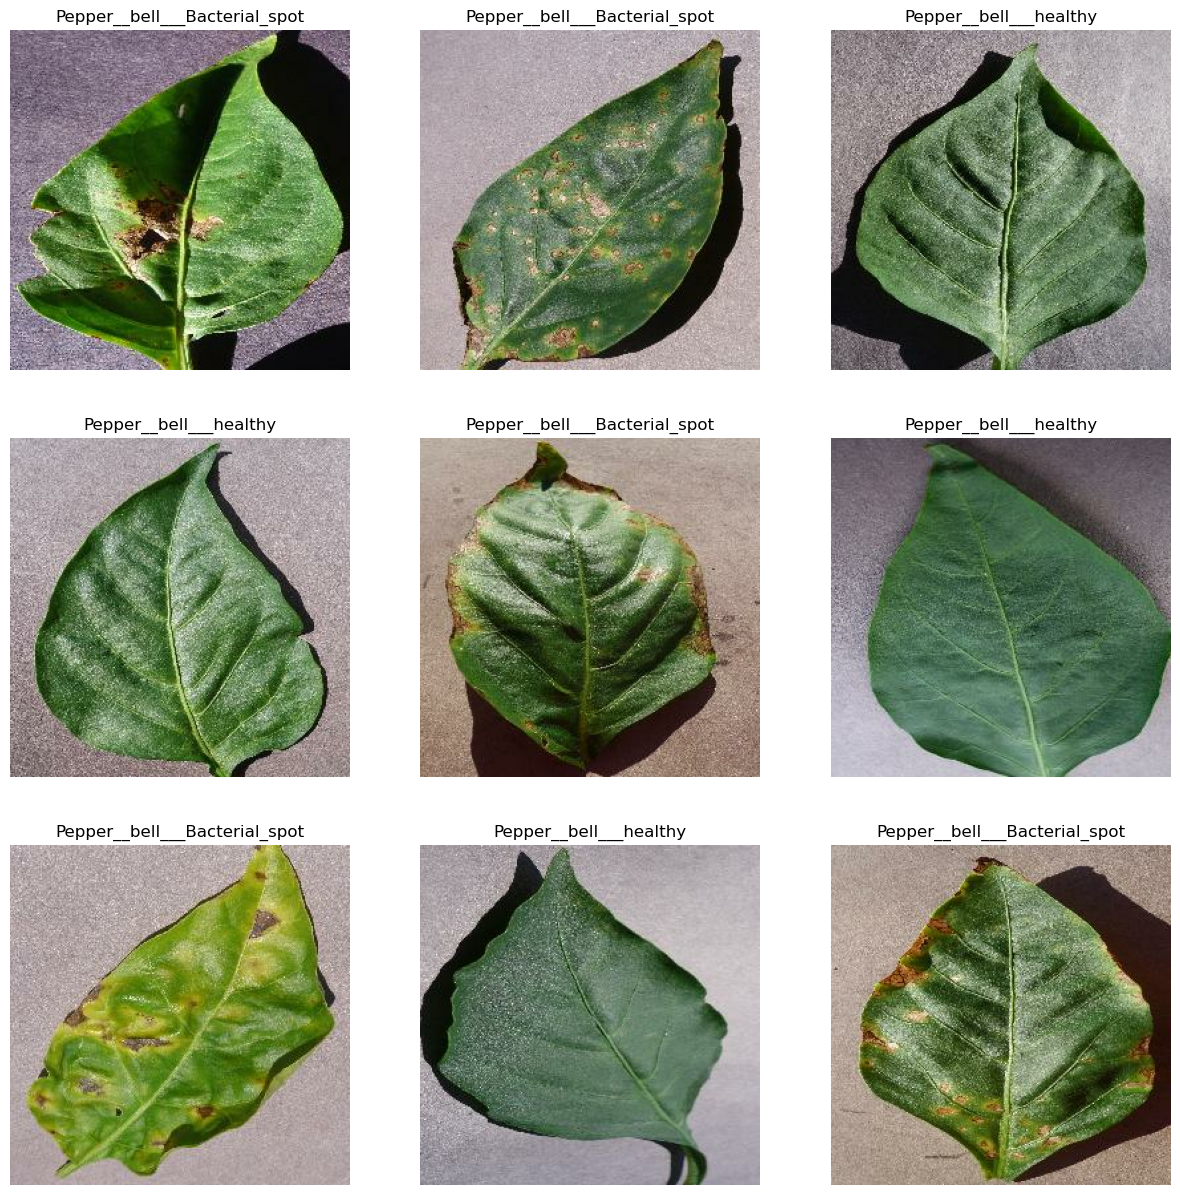

In [37]:
plt.figure(figsize=(15,15))
for image_batch, label_batch in bell_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3,3, i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

### Splitting dataset

In [38]:
train_ds, val_ds , test_ds = get_dataset_partitions_tf(bell_ds)
print(len(train_ds), len(val_ds), len(test_ds))

62 7 9


### Optimizing the dataset

In [39]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE) 

### Defining the model

In [40]:
def train_model(base_model, model_name):
    
    base_model = base_model(weights='imagenet', include_top=False, input_shape=(IMAGE_SIZE,IMAGE_SIZE,3))

    base_model.trainable = False

    n_classes = 2
    model = tf.keras.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(64, activation='relu'),
        layers.Dense(n_classes, activation='softmax')
    ])

    print("model used: ", model_name)
    model.compile(optimizer=Adam(learning_rate=1e-3),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    history = model.fit(train_ds, epochs=10, validation_data=val_ds)

    test_score = model.evaluate(test_ds)
    print(f"{model_name} Test Accuracy: {test_score[1]}")

    return history

### ResNet50

In [41]:
resnet_history = train_model(ResNet50, 'ResNet50')

model used:  ResNet50
Epoch 1/10
62/62 [==============================] - 217s 3s/step - loss: 0.2915 - accuracy: 0.8793 - val_loss: 0.1107 - val_accuracy: 0.9688
Epoch 2/10
62/62 [==============================] - 175s 3s/step - loss: 0.0815 - accuracy: 0.9715 - val_loss: 0.0741 - val_accuracy: 0.9821
Epoch 3/10
62/62 [==============================] - 165s 3s/step - loss: 0.0462 - accuracy: 0.9842 - val_loss: 0.0564 - val_accuracy: 0.9821
Epoch 4/10
62/62 [==============================] - 165s 3s/step - loss: 0.0318 - accuracy: 0.9918 - val_loss: 0.0345 - val_accuracy: 0.9911
Epoch 5/10
62/62 [==============================] - 164s 3s/step - loss: 0.0224 - accuracy: 0.9959 - val_loss: 0.0341 - val_accuracy: 0.9821
Epoch 6/10
62/62 [==============================] - 168s 3s/step - loss: 0.0176 - accuracy: 0.9969 - val_loss: 0.0145 - val_accuracy: 0.9955
Epoch 7/10
62/62 [==============================] - 166s 3s/step - loss: 0.0089 - accuracy: 0.9995 - val_loss: 0.0133 - val_accuracy

### EfficientNetB0

In [42]:
efficientnet_history = train_model(EfficientNetB0, 'EfficientNetB0')

model used:  EfficientNetB0
Epoch 1/10
62/62 [==============================] - 86s 1s/step - loss: 0.1724 - accuracy: 0.9358 - val_loss: 0.0572 - val_accuracy: 0.9688
Epoch 2/10
62/62 [==============================] - 70s 1s/step - loss: 0.0547 - accuracy: 0.9806 - val_loss: 0.0315 - val_accuracy: 0.9866
Epoch 3/10
62/62 [==============================] - 65s 1s/step - loss: 0.0313 - accuracy: 0.9913 - val_loss: 0.0214 - val_accuracy: 0.9955
Epoch 4/10
62/62 [==============================] - 63s 1s/step - loss: 0.0214 - accuracy: 0.9929 - val_loss: 0.0156 - val_accuracy: 1.0000
Epoch 5/10
62/62 [==============================] - 61s 992ms/step - loss: 0.0175 - accuracy: 0.9964 - val_loss: 0.0119 - val_accuracy: 1.0000
Epoch 6/10
62/62 [==============================] - 61s 994ms/step - loss: 0.0137 - accuracy: 0.9964 - val_loss: 0.0101 - val_accuracy: 1.0000
Epoch 7/10
62/62 [==============================] - 61s 982ms/step - loss: 0.0124 - accuracy: 0.9985 - val_loss: 0.0161 - val_

### MobileNetV2

In [43]:
mobilenet_history = train_model(MobileNetV2, 'MobileNetV2')

model used:  MobileNetV2
Epoch 1/10
62/62 [==============================] - 52s 780ms/step - loss: 0.2897 - accuracy: 0.8762 - val_loss: 0.1876 - val_accuracy: 0.9152
Epoch 2/10
62/62 [==============================] - 48s 779ms/step - loss: 0.1608 - accuracy: 0.9343 - val_loss: 0.1243 - val_accuracy: 0.9464
Epoch 3/10
62/62 [==============================] - 46s 737ms/step - loss: 0.1232 - accuracy: 0.9547 - val_loss: 0.1169 - val_accuracy: 0.9464
Epoch 4/10
62/62 [==============================] - 42s 686ms/step - loss: 0.1245 - accuracy: 0.9511 - val_loss: 0.1810 - val_accuracy: 0.9062
Epoch 5/10
62/62 [==============================] - 43s 695ms/step - loss: 0.0961 - accuracy: 0.9618 - val_loss: 0.0736 - val_accuracy: 0.9866
Epoch 6/10
62/62 [==============================] - 41s 669ms/step - loss: 0.0867 - accuracy: 0.9699 - val_loss: 0.0625 - val_accuracy: 0.9777
Epoch 7/10
62/62 [==============================] - 39s 636ms/step - loss: 0.0630 - accuracy: 0.9817 - val_loss: 0.05

### Visualization

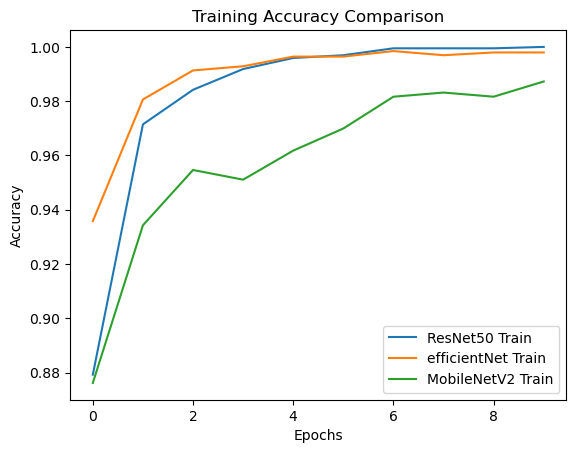

In [44]:
plt.plot(resnet_history.history['accuracy'], label='ResNet50 Train')
plt.plot(efficientnet_history.history['accuracy'], label='efficientNet Train')
plt.plot(mobilenet_history.history['accuracy'], label='MobileNetV2 Train')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training Accuracy Comparison')
plt.show()

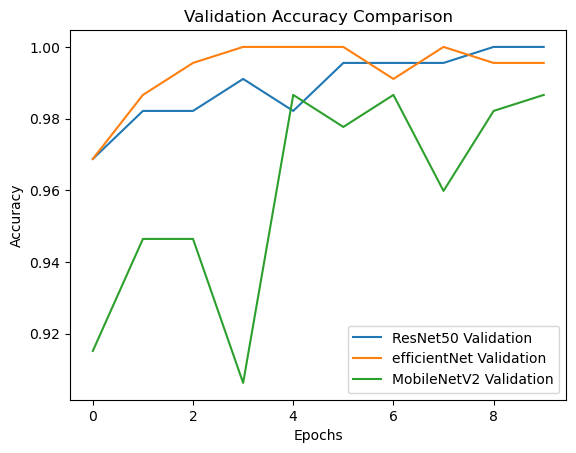

In [45]:
plt.plot(resnet_history.history['val_accuracy'], label='ResNet50 Validation')
plt.plot(efficientnet_history.history['val_accuracy'], label='efficientNet Validation')
plt.plot(mobilenet_history.history['val_accuracy'], label='MobileNetV2 Validation')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Validation Accuracy Comparison')
plt.show()